In [2]:
import pandas as pd
from pydub import AudioSegment
import os
from birdclassification.preprocessing.filtering import filter_recordings_30

#ESC50
esc50_original_csv = "/Users/zosia/Desktop/NotBirds/Original_csv/esc50.csv"
esc50_audio = "/Users/zosia/Desktop/NotBirds/ESC50"
esc50_output_audio = "/Users/zosia/Desktop/NotBirds/ESC50"

#Audioset
audioset_original_csv = "/Users/zosia/Desktop/NotBirds/Original_csv/audioset.csv"
audioset_original_csv_labels = "/Users/zosia/Desktop/NotBirds/Original_csv/audioset_labels.csv"
audioset_audio = "/Users/zosia/Desktop/NotBirds/Audioset"
audioset_output_audio = "/Users/zosia/Desktop/NotBirds/Audioset"

#WARBLRB
warblrb_original_csv = "/Users/zosia/Desktop/NotBirds/Original_csv/warblrb.csv"
warblrb_audio = "/Users/zosia/Desktop/NotBirds/Warblrb"
warblrb_output_audio = "/Users/zosia/Desktop/NotBirds/Warblrb"

#Freefield
freefield_original_csv = "/Users/zosia/Desktop/NotBirds/Original_csv/freefield.csv"
freefield_audio = "/Users/zosia/Desktop/NotBirds/Freefield"
freefield_output_audio = "/Users/zosia/Desktop/NotBirds/Freefield"

#Output CSV
output_folder_all = "/Users/zosia/Desktop/data.csv"
output_folder_noises = "/Users/zosia/Desktop/noises.csv"

In [3]:
def convert(recordings_folder, output_folder):
    i=0
    for filename in os.listdir(recordings_folder):
        i+=1
        if filename.endswith(".wav"):
            input_path = os.path.join(recordings_folder, filename)
            output_filename = os.path.splitext(filename)[0] + '.ogg'
            output_path = os.path.join(output_folder, output_filename)
    
            sound = AudioSegment.from_wav(input_path)
            sound = sound.set_frame_rate(32000)
            sound.export(output_path, format="ogg")
            if i%100==0:
                print(i)

In [3]:
def delete_files(bird_files, path, row_name):
    for index, row in bird_files.iterrows():
        filename = row[row_name]
        file_path = os.path.join(path, filename)
        try:
            os.remove(file_path)
            print(f"Deleted: {file_path}")
        except FileNotFoundError:
            print("Not found")
        except Exception as e:
            print(f"Error deleting file {file_path}: {e}")

### ESC50

In [4]:
df = pd.read_csv(esc50_original_csv, delimiter=",")
print("Overall size: ", df.shape[0])

Overall size:  2000


In [5]:
categories_to_delete = ['rooster', 'hen', 'crow', 'chirping_birds']
bird_files = df[df['category'].isin(categories_to_delete)]

#delete_files(bird_files, esc50_audio, 'filename')

new_df = df[~df['filename'].isin(bird_files['filename'])]

new_df = new_df[['filename']]
new_df['isBird'] = 0
new_df['folder'] = 'ESC50'
new_df['filename'] = new_df['filename'].str.replace('.wav', '')
esc50_df = new_df

In [6]:
print("Size after excluding chosen categories: ", esc50_df.shape[0])

Size after excluding chosen categories:  1840


In [7]:
if sum([len(files) for root, dirs, files in os.walk(esc50_output_audio)]) <= esc50_df.shape[0]:
    convert(esc50_audio, esc50_output_audio)

### WARBLRB

In [8]:
df = pd.read_csv(warblrb_original_csv, delimiter=",")
print("Overall size: ", df.shape[0])

Overall size:  8000


In [9]:
bird_files = df[df['hasbird'] == 1]

#delete_files(bird_files, warblrb_audio, 'itemid')

new_df = df[df['hasbird'] == 0]
new_df = new_df[['itemid', 'hasbird']]
new_df['folder'] = 'Warblrb'
new_df.rename(columns={'itemid': 'filename', 'hasbird': 'isBird'}, inplace=True)
warblrb_df = new_df

In [10]:
print("Size after excluding chosen categories: ", warblrb_df.shape[0])

Size after excluding chosen categories:  1955


In [11]:
if sum([len(files) for root, dirs, files in os.walk(warblrb_output_audio)]) <= warblrb_df.shape[0]:
    convert(warblrb_audio, warblrb_output_audio)

### AUDIOSET

In [12]:
df_classes = pd.read_csv(audioset_original_csv, delimiter=',')
df_labels = pd.read_csv(audioset_original_csv_labels, delimiter=',')

In [13]:
df_classes['positive_labels'] = df_classes['positive_labels'].str.split(',')
df_classes = df_classes.explode('positive_labels')

merged_df = pd.merge(df_classes, df_labels, left_on='positive_labels', right_on='mid')
df = merged_df.groupby('YTID')['display_name'].agg(list).reset_index()
print("Overall size: ", df.shape[0])

Overall size:  19644


In [14]:
categories_to_delete = ['Bird', 'Bird vocalization, bird call, bird song', 'Chirp, tweet', 'Squawk', 'Pigeon, dove', 'Coo', 'Crow', 'Caw', 'Owl', 'Hoot', 'Bird flight, flapping wings', 'Fowl', 'Chicken, rooster', 'Cluck', 'Crowing cock-a-doodle-doo', 'Turkey', 'Gobble', 'Duck', 'Quack', 'Goose', 'Honk', 'Field recording', 'Croak', 'Squeal', 'Chirp tone', 'Wild animals']
bird_files = df[df['display_name'].apply(lambda x: any(cat in x for cat in categories_to_delete))]

#delete_files(bird_files, audioset_audio, 'YTID')

new_df = df[~df['display_name'].isin(bird_files['display_name'])].copy()

new_df.loc[:, 'folder'] = 'Audioset'
new_df.loc[:, 'isBird'] = 0
new_df.rename(columns={'YTID': 'filename'}, inplace=True)
audioset_df = new_df[['filename', 'isBird', 'folder']].copy()

In [15]:
print("Size after excluding chosen categories: ", audioset_df.shape[0])

Size after excluding chosen categories:  18779


In [16]:
if sum([len(files) for root, dirs, files in os.walk(audioset_output_audio)]) <= audioset_df.shape[0]:
    convert(audioset_audio, audioset_output_audio)

### Freefiled

In [17]:
df = pd.read_csv(freefield_original_csv, delimiter=",")
print("Overall size: ", df.shape[0])

Overall size:  7690


In [18]:
#bird_files = df[df['hasbird'] == 1]
#delete_files(bird_files, freefield_audio, 'itemid')

new_df = df[df['hasbird'] == 0]
new_df = new_df[['itemid', 'hasbird']]
new_df['folder'] = 'Freefield'
new_df.rename(columns={'itemid': 'filename', 'hasbird': 'isBird'}, inplace=True)
freefield_df = new_df

In [19]:
print("Size after excluding chosen categories: ", freefield_df.shape[0])

Size after excluding chosen categories:  5755


In [20]:
if sum([len(files) for root, dirs, files in os.walk(freefield_output_audio)]) <= freefield_df.shape[0]:
    convert(freefield_audio, freefield_output_audio)

### Bird sounds

In [21]:
df = filter_recordings_30()
birds_df = df[['id', 'Latin name']].copy()
birds_df['isBird'] = 1
birds_df.rename(columns={'id': 'filename', 'Latin name': 'folder'}, inplace=True)

/Users/zosia/Desktop/Bird-classification-model/birdclassification/preprocessing/filtering.py:72: DtypeWarning: Columns (10,39,43,44,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  recordings = pd.read_csv(filepath_recordings)


### Merge datasets

In [22]:
result_df = pd.concat([esc50_df, warblrb_df, audioset_df, freefield_df, birds_df], ignore_index=True)
result_df.to_csv(output_folder_all)
print("Not-Bird recordings: ", result_df[result_df['isBird'] == 0].shape[0])
print("Bird recordings: ", result_df[result_df['isBird'] == 1].shape[0])

Not-Bird recordings:  28329
Bird recordings:  41209


#### Duplicates

In [23]:
duplicates = result_df.duplicated(subset='filename', keep=False)
duplicate_count = duplicates.sum()
print("Duplicate count: ", duplicate_count)

Duplicate count:  296


### Just noises df

In [24]:
noises_df = result_df[result_df['isBird'] == 0]
noises_df = noises_df[['filename', 'folder']]
print(noises_df)
noises_df.to_csv(output_folder_noises)

            filename     folder
0       1-100032-A-0      ESC50
1      1-100210-A-36      ESC50
2      1-100210-B-36      ESC50
3      1-101296-A-19      ESC50
4      1-101296-B-19      ESC50
...              ...        ...
28324          95027  Freefield
28325          80708  Freefield
28326         168059  Freefield
28327         164922  Freefield
28328          40565  Freefield

[28329 rows x 2 columns]


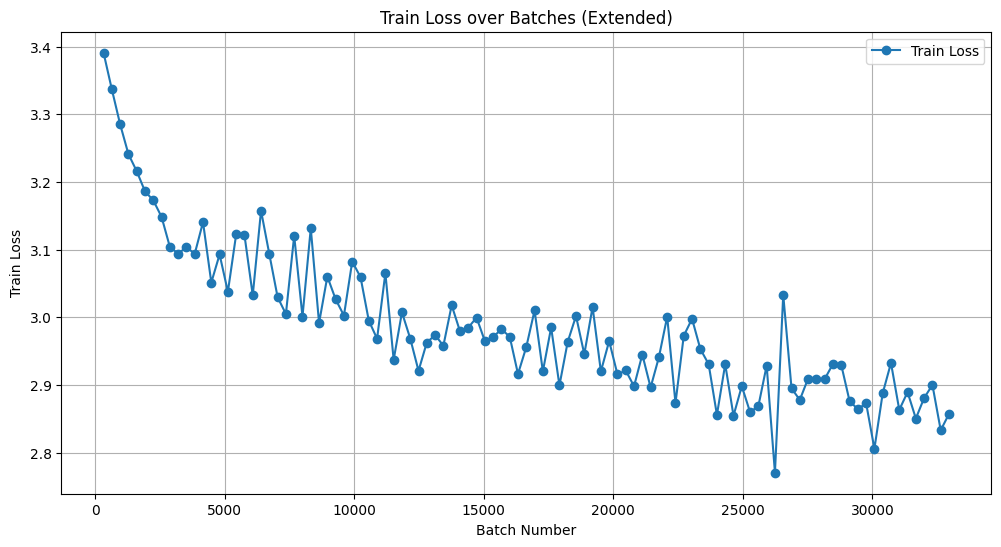

In [4]:
import matplotlib.pyplot as plt

# Extended Data
batch_numbers_extended = [i * 32 for i in range(10, 1031, 10)]
loss_values_extended = [
    3.3909, 3.3368, 3.2852, 3.2411, 3.2159, 3.1861, 3.1728, 3.1483, 3.1040, 3.0939,
    3.1037, 3.0937, 3.1406, 3.0513, 3.0928, 3.0377, 3.1226, 3.1216, 3.0324, 3.1575,
    3.0933, 3.0297, 3.0048, 3.1205, 3.0009, 3.1315, 2.9915, 3.0602, 3.0266, 3.0025,
    3.0823, 3.0595, 2.9951, 2.9683, 3.0653, 2.9371, 3.0073, 2.9686, 2.9209, 2.9627,
    2.9737, 2.9580, 3.0178, 2.9794, 2.9847, 2.9996, 2.9649, 2.9710, 2.9822, 2.9715,
    2.9162, 2.9560, 3.0101, 2.9200, 2.9849, 2.8993, 2.9638, 3.0019, 2.9454, 3.0152,
    2.9200, 2.9649, 2.9156, 2.9214, 2.8980, 2.9449, 2.8963, 2.9409, 3.0009, 2.8731,
    2.9727, 2.9977, 2.9531, 2.9308, 2.8557, 2.9307, 2.8545, 2.8982, 2.8599, 2.8687,
    2.9286, 2.7703, 3.0333, 2.8950, 2.8779, 2.9094, 2.9095, 2.9087, 2.9310, 2.9296,
    2.8764, 2.8640, 2.8731, 2.8057, 2.8876, 2.9325, 2.8632, 2.8894, 2.8504, 2.8808,
    2.9000, 2.8331, 2.8572
]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(batch_numbers_extended, loss_values_extended, label='Train Loss', marker='o')
plt.xlabel('Batch Number')
plt.ylabel('Train Loss')
plt.title('Train Loss over Batches (Extended)')
plt.legend()
plt.grid(True)
plt.show()
